## _Track Evaluation_

- Running _`trkx_from_gnn.py`_ produces recostucted tracks (track candiates)
- Running _`trkx_reco_eval.py`_ gives reconstruction evaluation: _`eff, fake rate, dup. rate, etc`_

Let's perform inspection after track evaluation.

In [1]:
import sys, os, glob, yaml

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import pprint
import seaborn as sns
import trackml.dataset

In [4]:
import torch
from torch_geometric.data import Data
import itertools

In [5]:
sys.path.append('..')

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## _A. Inspection of Epsilon in DBSCAN_

1. Various $\epsilon$ for DBSCAN in `trkx_from_gnn.py`
2. Choose the best $\epsilon$ based on _`eff, fake rate, dup. rate`_) after `trkx_reco_eval.py`

**NOTE:** The $\epsilon$ in DBSCAN is alternative to chosing a cut on the `edge_score`.

In [7]:
# lists from eval_summary.txt
e_list = [0.10, 0.15, 0.20, 0.25, 0.35, 0.45, 0.55, 0.75, 0.85, 0.95]
eff_list = [90.86,91.68,91.68,91.58,89.84,87.58,85.83,83.57,81.52,76.28]

In [8]:
# covert to ndarrays
eff = np.array(eff_list)
epsilon = np.array(e_list)

In [9]:
# plt.style.use('ggplot')
# mpl.rcParams.update(mpl.rcParamsDefault)

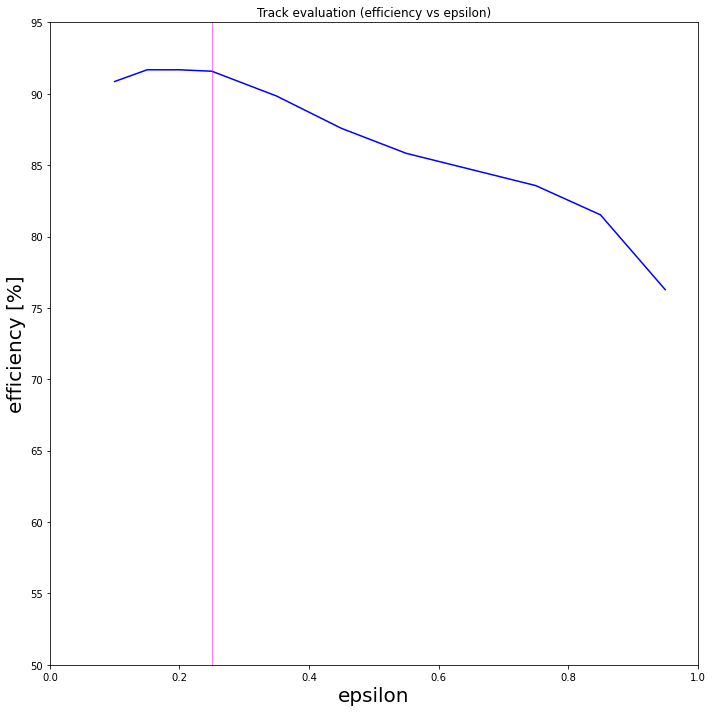

In [10]:
# init subplots
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,10))
ax.plot(epsilon, eff, linestyle='-', linewidth=1.5, color='blue')

plt.axvline(x=0.25, linewidth=0.5, color='magenta')

# plotting params
ax.set_title('Track evaluation (efficiency vs epsilon)')
ax.set_xlabel('epsilon', fontsize=20)
ax.set_ylabel('efficiency [%]', fontsize=20)
ax.set_xlim(0, 1)
ax.set_ylim(50, 95)
ax.grid(False)
fig.tight_layout()
# fig.savefig("epsilon_eff.png")

## _B. Visualize Test Data_

Inspect easy to difficult to reconstruct tracks. Choose 10 such events and use `score_cut=0.25`

In [11]:
inputdir="run/gnn_evaluation/test"
proc_files = sorted(glob.glob(os.path.join(inputdir, "*")))

In [12]:
feature_data = torch.load(proc_files[0], map_location=device)

In [13]:
feature_data

Data(x=[148, 3], pid=[148], layers=[148], event_file='/global/cscratch1/sd/aakram/train_all/event0000095000', hid=[148], pt=[148], modulewise_true_edges=[2, 139], layerwise_true_edges=[2, 143], edge_index=[2, 961], y_pid=[961], scores=[1922])

In [14]:
event_id = int(os.path.basename(feature_data.event_file)[-4:])

In [15]:
event_id

5000

## _(C.) Post Analysis_

- Read evaluation data

In [16]:
sys.path.append('..')

In [17]:
from src.drawing import detector_layout, draw_proc_event
from src.utils_math import polar_to_cartesian

In [18]:
# select event index (glob will fetch events as a list)
event_idx = 1

### _(1.) Read True Tracks_

In [19]:
# get list of true tracks (test dataset)
inputdir="run/gnn_evaluation/test"
true_trkx = sorted(glob.glob(os.path.join(inputdir, "*")))

In [20]:
# event Data
true_track = torch.load(true_trkx[event_idx], map_location=device)
print("Length of Data: {}".format(len(true_track)))

Length of Data: 11


In [21]:
true_track

Data(x=[171, 3], pid=[171], layers=[171], event_file='/global/cscratch1/sd/aakram/train_all/event0000095001', hid=[171], pt=[171], modulewise_true_edges=[2, 160], layerwise_true_edges=[2, 172], edge_index=[2, 808], y_pid=[808], scores=[1616])

In [22]:
# hit features
r, phi, ir = true_track.x.T

In [23]:
# spatial coordinate transform
x, y = polar_to_cartesian(r.detach().numpy(), phi.detach().numpy())

In [24]:
# compensate scaling
ir = ir.detach().numpy()*100

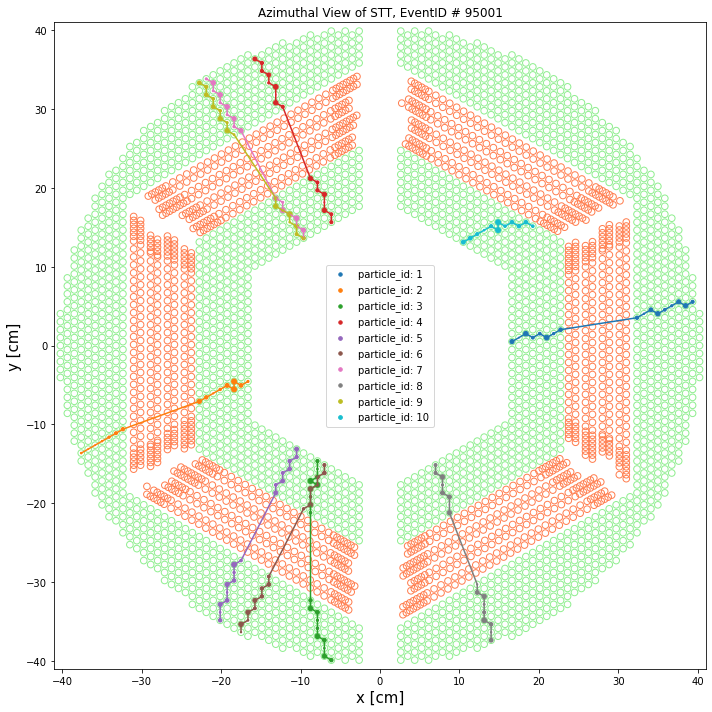

In [25]:
# plot true event
fig, ax = detector_layout(figsize=(10,10))
e_id = int(true_track.event_file[-10:])
p_ids = np.unique(true_track.pid)

for pid in p_ids:
    idx = true_track.pid == pid
    ax.plot(x[idx], y[idx], '-', linewidth=1.5)
    ax.scatter(x[idx], y[idx], s=(ir[idx]*50), label='particle_id: {}'.format(int(pid)))

ax.set_title('Azimuthal View of STT, EventID # {}'.format(e_id))
ax.legend(fontsize=10, loc='best')
fig.tight_layout()
# fig.savefig("true_track.png")

### _(2.) Read Reco Track_

In [26]:
inputdir="run/trkx_from_gnn"
reco_trkx = sorted(glob.glob(os.path.join(inputdir, "*")))

In [27]:
print("Track Id: ", reco_trkx[event_idx])

Track Id:  run/trkx_from_gnn/5001


In [28]:
reco_track = torch.load(reco_trkx[event_idx], map_location=device)
print("Length of Data: {}".format(len(reco_track)))

Length of Data: 171


In [29]:
reco_track.head()

,hit_id,track_id
0,222,0
1,171,1
2,16,2
3,42,3
4,67,-1


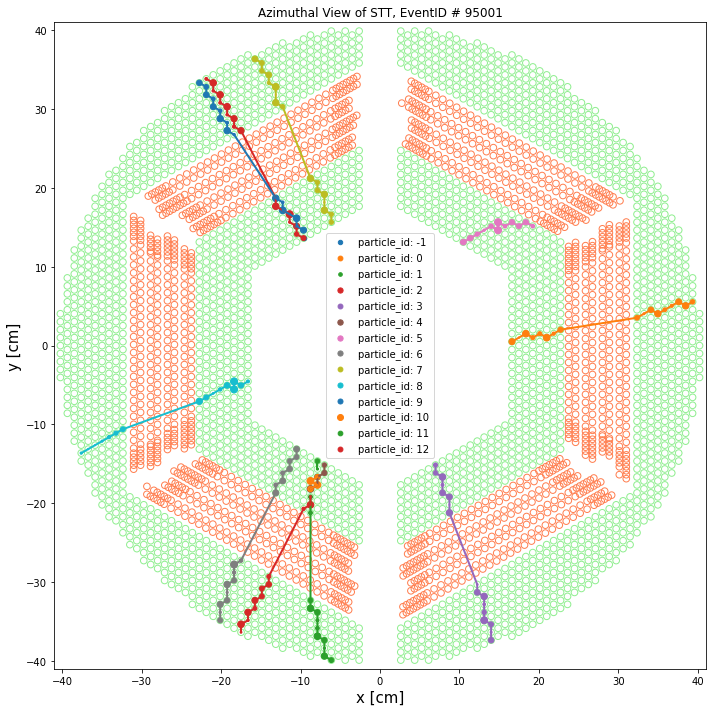

In [30]:
# plot reco event, here, (x,y,ir) comes from ture event. but idx is from reco event
fig, ax = detector_layout(figsize=(10,10))
e_id = e_id
t_ids = np.unique(reco_track.track_id)

for tid in t_ids:
    idx = reco_track.track_id == tid
    ax.plot(x[idx], y[idx], '-', linewidth=2)
    ax.scatter(x[idx], y[idx], s=(ir[idx]*100), label='particle_id: {}'.format(tid))
    
ax.set_title('Azimuthal View of STT, EventID # {}'.format(e_id))
ax.legend(fontsize=10, loc='best')
fig.tight_layout()
# fig.savefig("reco_track.png")

### _(3.) Read Track Evaluation Data_

In [31]:
inputdir="run/trkx_reco_eval"

In [32]:
evtid = int(reco_trkx[event_idx][-4:])

In [33]:
print("evtid: {}".format(evtid))

evtid: 5001


In [34]:
!./eval.sh $evtid

Out of 5000 events processing 1 events with 1 workers
Output directory: /home/adeel/current/3_deeptrkx/ctd2022/eval/run/trkx_reco_eval
Running 5001


In [35]:
# path to HDF5 Store
hdf5_path = inputdir+"/{}_particles.h5".format(evtid)
print(hdf5_path)

run/trkx_reco_eval/5001_particles.h5


In [36]:
df = pd.read_hdf(hdf5_path)
print("Length of Data: {}".format(len(df)))

Length of Data: 10


In [37]:
df.head()

,particle_id,pt,n_true_hits,is_matched,is_trackable,evtid
0,1,0.372869,17,True,True,5001
1,3,0.125288,19,True,True,5001
2,9,0.979851,18,True,True,5001
3,8,0.549459,17,True,True,5001
4,7,1.140847,18,True,True,5001


In [38]:
# Read the Summary of Evaluation
sum_path = inputdir+"/{}_summary.txt".format(evtid)
print(sum_path)

run/trkx_reco_eval/5001_summary.txt


In [39]:
with open(sum_path) as f:
    contents = f.read()
    print(contents)

--------------------------------------------------
Run Time:      20220530-232559
Reconstructed tracks: /home/adeel/current/3_deeptrkx/ctd2022/eval/run/trkx_from_gnn
# of events: 1
Truth tracks:                   10
Truth tracks matched:                   10
Reco. tracks:                   12
Reco. tracks matched:                   12
Reco. tracks matched to POI:                   12
Reco. tracks duplicated:                    2
Tracking Eff.:             100.0000%
Fake rate:                   0.0000%
Duplication Rate:              16.6667%

